
--- Menú Principal ---
1. Ingresar nombre de la criptomoneda
2. Ver gráfica de la criptomoneda
3. Gráfica de las 4 criptomonedas más relevantes en 2015
4. Verificar estabilidad de una criptomoneda en 2015
5. Grafico de estabilidad por criptomoneda
6. Criptomonedas por encima de la media en 2015
7. Ver Integración Social
8. Gráfico de estabilidad por moneda ordinaria
9. Salir
Agrupación de porcentaje de propiedad:
137 países, representando el 93.20% del total, tienen menos o igual al 10% de propiedad.
145 países, representando el 98.64% del total, tienen menos o igual al 20% de propiedad.
146 países, representando el 99.32% del total, tienen menos o igual al  30% de propiedad.
147 países, representando el 100.00% del total, tienen menos o igual al 50% de propiedad.
147 países, representando el 100.00% del total, tienen menos o igual al 100% de propiedad.


/tmp/ipykernel_96819/2183857337.py:245: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_index_2023, y='Country', x='Ownership Percentage', palette='viridis', legend=False)


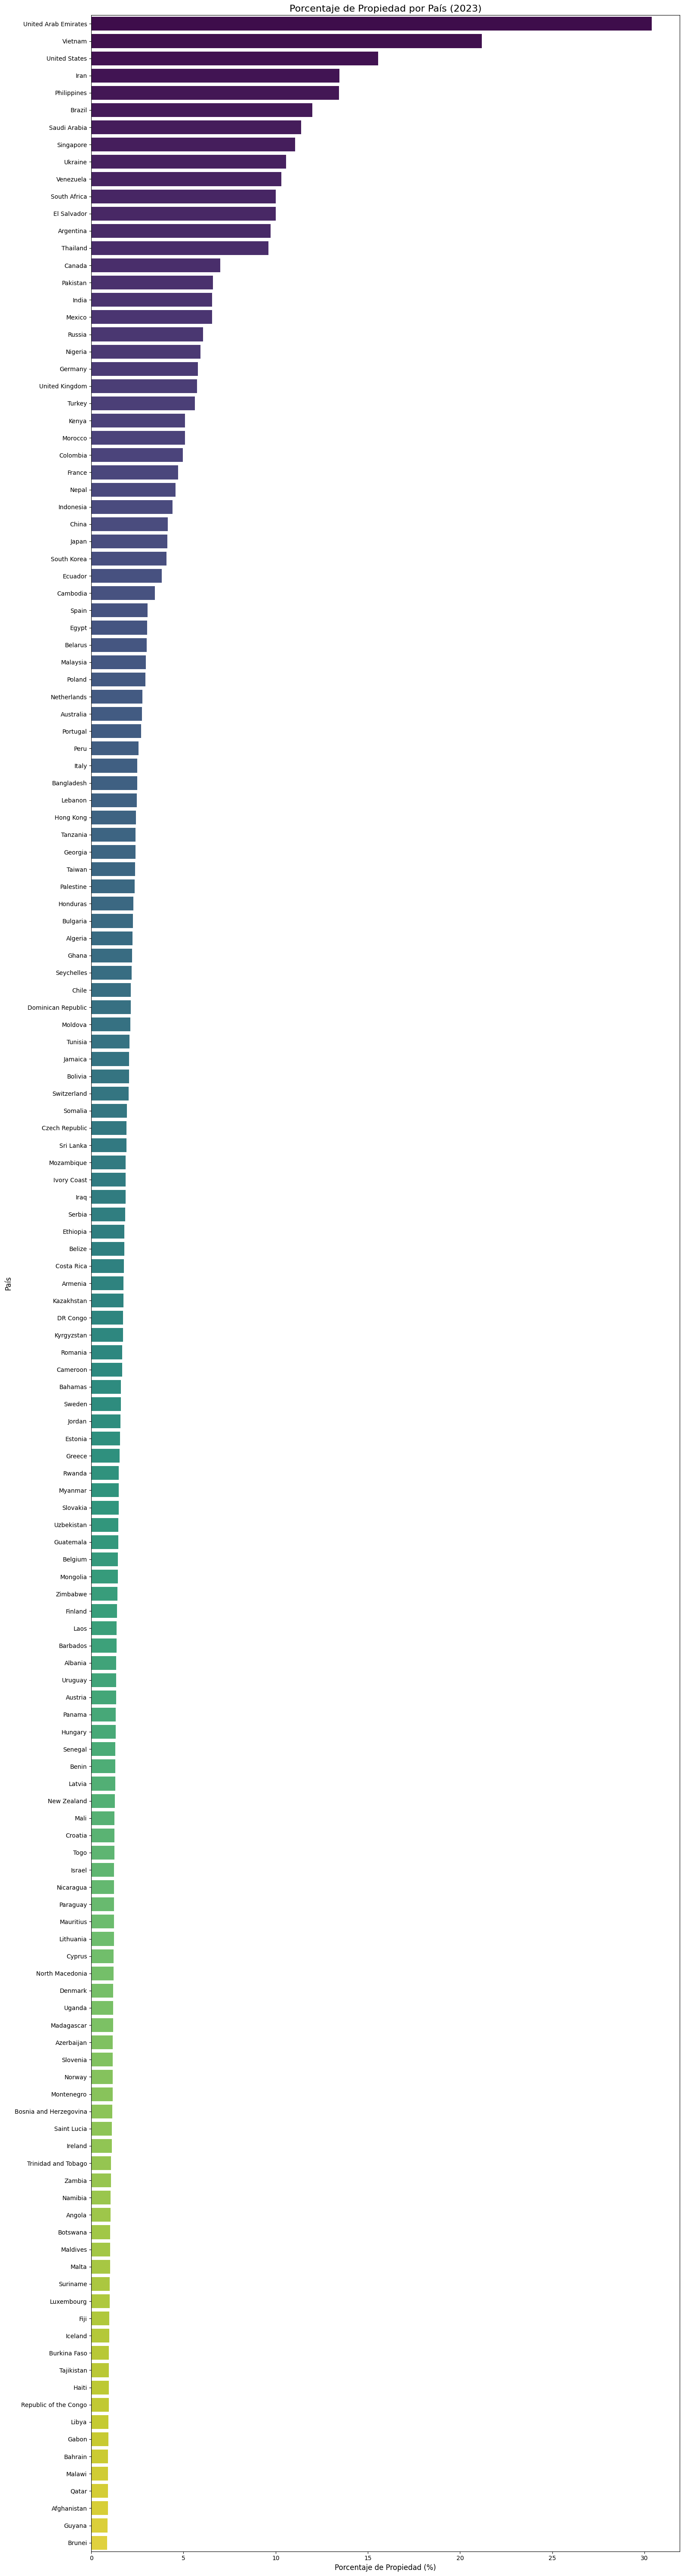


--- Menú Principal ---
1. Ingresar nombre de la criptomoneda
2. Ver gráfica de la criptomoneda
3. Gráfica de las 4 criptomonedas más relevantes en 2015
4. Verificar estabilidad de una criptomoneda en 2015
5. Grafico de estabilidad por criptomoneda
6. Criptomonedas por encima de la media en 2015
7. Ver Integración Social
8. Gráfico de estabilidad por moneda ordinaria
9. Salir
Saliendo del programa...


In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import difflib

ruta_datos = './DataEconomyCripto'

def cargar_datos():
    archivos = [archivo for archivo in os.listdir(ruta_datos) if archivo.endswith('.csv')]
    datos_cripto = {}
    for archivo in archivos:
        nombre_moneda = archivo.split('.')[0].lower()
        try:
            df = pd.read_csv(os.path.join(ruta_datos, archivo))
            mapa_renombrar = {'Date': 'Fecha', 'date': 'Fecha', 'Timestamp': 'Fecha', 'fecha': 'Fecha',
                            'price': 'Precio', 'total_volume': 'Volumen', 'market_cap': 'Capitalizacion'}

            df.rename(columns={k: v for k, v in mapa_renombrar.items() if k in df.columns}, inplace=True)
            if 'Fecha' in df.columns:
                df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
            if 'Precio' in df.columns:
                df['Precio'] = pd.to_numeric(df['Precio'], errors='coerce')
            if 'Volumen' in df.columns:
                df['Volumen'] = pd.to_numeric(df['Volumen'], errors='coerce')
            if 'Capitalizacion' in df.columns:
                df['Capitalizacion'] = pd.to_numeric(df['Capitalizacion'], errors='coerce')
            df.dropna(subset=['Fecha', 'Precio'], inplace=True)
            datos_cripto[nombre_moneda] = df
        except Exception as e:
            print(f"Error al procesar {archivo}: {e}")

    return datos_cripto

def sugerir_criptomoneda(entrada, crypto_data):
    available_coins = list(crypto_data.keys())
    sugerencias = difflib.get_close_matches(entrada.lower(), available_coins, n=5, cutoff=0.4)

    if sugerencias:
        print("\n¿Quisiste decir alguna de estas criptomonedas?")
        for i, sugerencia in enumerate(sugerencias, 1):
            print(f"{i}. {sugerencia.capitalize()}")
        return sugerencias
    else:
        print("\nNo se encontraron coincidencias exactas.")
        return []

def criptomonedas_encima_media(crypto_data):
    overall_mean = np.mean([df[df['Date'].dt.year == 2015]['Price'].mean() for df in crypto_data.values() if not df[df['Date'].dt.year == 2015].empty])
    above_average_coins = [coin for coin, df in crypto_data.items() if df[df['Date'].dt.year == 2015]['Price'].mean() > overall_mean]

    print("\nCriptomonedas con precio medio por encima de la media en 2015:")
    for coin in above_average_coins:
        print(f"{coin.capitalize()}")

def calcular_estadisticas(crypto_data):
    crypto_stats = {}
    for coin, df in crypto_data.items():
        for year in range(2015, 2025):
            df_year = df[df['Fecha'].dt.year == year]
            mean_price = df_year['Precio'].mean()
            std_price = df_year['Precio'].std()
            if coin not in crypto_stats:
                crypto_stats[coin] = {}
            crypto_stats[coin][year] = {'mean': mean_price, 'std': std_price}
    return crypto_stats

def criptomonedas_encima_media(crypto_data):
    precios_medios = []
    for coin, df in crypto_data.items():
        if 'Fecha' in df.columns:
            df['Fecha'] = pd.to_datetime(df['Fecha'], errors='coerce')
            df_2015 = df[df['Fecha'].dt.year == 2015]
            mean_price = df_2015['Precio'].mean() if not df_2015.empty else None
            if mean_price is not None and not np.isnan(mean_price):
                precios_medios.append((coin, mean_price))

    if not precios_medios:
        print("No hay datos válidos para calcular estadísticas en 2015.")
        return

    overall_mean = np.mean([precio for _, precio in precios_medios])

    above_average_coins = [coin for coin, precio in precios_medios if precio > overall_mean]
    print("\nCriptomonedas con precio medio por encima de la media en 2015:")
    for coin in above_average_coins:
        print(f"{coin.capitalize()}")

def verificar_estabilidad(coin_name, crypto_data, crypto_stats):
    years = list(range(2015, 2025))
    print("\nSeleccione el año para verificar la estabilidad:")
    for year in years:
        print(year)

    while True:
        try:
            selected_year = int(input("Ingrese el año: "))
            if selected_year not in years:
                raise ValueError("Año no válido.")
            break
        except ValueError as e:
            print(e)

    if coin_name not in crypto_data:
        print(f"\nNo se encontró la criptomoneda '{coin_name}'.")
        sugerencias = sugerir_criptomoneda(coin_name, crypto_data)
        if sugerencias:
            seleccion = input("\nSeleccione el número de la criptomoneda o presione Enter para cancelar: ")
            if seleccion.isdigit() and 1 <= int(seleccion) <= len(sugerencias):
                coin_name = sugerencias[int(seleccion) - 1]
            else:
                print("Operación cancelada.")
                return

    if coin_name in crypto_data:
        stats = crypto_stats.get(coin_name, {}).get(selected_year)
        if stats:
            mean_price = stats['mean']
            std_price = stats['std']
            print(f"\nEstabilidad de {coin_name.capitalize()} en {selected_year}:")
            print(f"Precio medio: ${mean_price:.2f}")
            print(f"Desviación estándar: ${std_price:.2f}")
            if std_price < mean_price * 0.1:
                print(f"{coin_name.capitalize()} fue estable en {selected_year}.")
            else:
                print(f"{coin_name.capitalize()} no fue estable en {selected_year}.")
        else:
            print(f"\nNo se encontraron datos para {coin_name.capitalize()} en {selected_year}.\n")
    else:
        print(f"\nNo se encontraron datos para {coin_name.capitalize()} en {selected_year}.\n")

def mostrar_estabilidad(nombre_moneda, datos_cripto):
    if nombre_moneda in datos_cripto:
        df = datos_cripto[nombre_moneda]
        df['Año'] = df['Fecha'].dt.year
        estabilidad = df.groupby('Año')['Precio'].agg(['mean', 'std']).reset_index()
        estabilidad['CV'] = estabilidad['std'] / estabilidad['mean'] * 100
        estabilidad = estabilidad

        plt.figure(figsize=(10, 6))
        plt.ylim(0,100)
        plt.plot(estabilidad['Año'], estabilidad['CV'], marker='o', label='Porcentaje de Estabilidad')
        plt.title(f"Estabilidad anual de {nombre_moneda.capitalize()}")
        plt.xlabel('Año')
        plt.ylabel('Porcentaje de Estabilidad')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.ylim(0,100)
        sns.barplot(x='Año', y='CV', data=estabilidad)
        plt.title(f'CV Anual de {nombre_moneda.capitalize()}')
        plt.xlabel('Año')
        plt.ylabel('Porcentaje de Estabilidad')
        plt.grid(True)
        plt.show()

    else:
        print(f"\nCriptomoneda {nombre_moneda} no encontrada.\n")

def mostrar_estadisticas(nombre_moneda):
    df = datos_cripto.get(nombre_moneda)
    if df is not None:
        print(f"\nEstadísticas de {nombre_moneda.capitalize()}:")
        print(df.describe(), "\n")
    else:
        print(f"\nCriptomoneda {nombre_moneda} no encontrada.\n")

def ver_grafica(nombre_moneda):
    df = datos_cripto.get(nombre_moneda)
    if df is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(df['Fecha'], df['Precio'], label=nombre_moneda.capitalize())
        plt.title(f'Evolución del precio de {nombre_moneda.capitalize()}')
        plt.xlabel('Fecha')
        plt.ylabel('Precio (USD)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(f"\nCriptomoneda {nombre_moneda} no encontrada.\n")

def grafica_relevantes(crypto_data):
    relevantes = ['bitcoin', 'ethereum', 'dogecoin', 'litecoin']
    print("\nSeleccione el tipo de gráfica:")
    print("1. Línea")
    print("2. Boxplot")
    print("3. Scatterplot")

    while True:
        try:
            tipo_grafica = input("Ingrese el número de la opción: ")
            if tipo_grafica not in ['1', '2', '3']:
                raise ValueError("Opción no válida.")
            break
        except ValueError as e:
            print(e)

    plt.figure(figsize=(10, 6))
    for coin in relevantes:
        if coin in crypto_data:
            df = crypto_data[coin]
            df_2015 = df[df['Fecha'].dt.year == 2015]
            if tipo_grafica == '1':
                plt.plot(df_2015['Fecha'], df_2015['Precio'], label=coin.capitalize())
            elif tipo_grafica == '2':
                sns.boxplot(x=df_2015['Fecha'].dt.month, y=df_2015['Precio'], label=coin.capitalize())
            elif tipo_grafica == '3':
                sns.scatterplot(x=df_2015['Fecha'], y=df_2015['Precio'], label=coin.capitalize())

    plt.title('Evolución de precios de las criptomonedas más relevantes en 2015')
    plt.xlabel('Fecha')
    plt.ylabel('Precio (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

def integracion_social():
    ruta_index = "./DataSocial/cripto_index.csv"
    df_index = pd.read_csv(ruta_index, sep=';', thousands=',')
    df_index_2023 = df_index[['Country', 'Ownership Percentage']]
    df_index_2023.loc[:, 'Ownership Percentage'] = df_index_2023['Ownership Percentage'].str.replace('%', '').astype(float)
    df_index_2023 = df_index_2023.sort_values(by='Ownership Percentage', ascending=False)
    df_index_2023 = df_index_2023[df_index_2023['Ownership Percentage'] > 0]
    
    total_paises = len(df_index_2023)
    rangos = {
        "10%": (df_index_2023['Ownership Percentage'] <= 10).sum(),
        "20%": (df_index_2023['Ownership Percentage'] <= 20).sum(),
        " 30%": (df_index_2023['Ownership Percentage'] <= 30).sum(),
        "50%": (df_index_2023['Ownership Percentage'] <= 50).sum(),
        "100%": (df_index_2023['Ownership Percentage'] <= 100).sum()
    }
    
    print("Agrupación de porcentaje de propiedad:")
 
    for rango, cantidad in rangos.items():
        porcentaje = (cantidad / total_paises) * 100
        print(f"{cantidad} países, representando el {porcentaje:.2f}% del total, tienen menos o igual al {rango} de propiedad.")


    plt.figure(figsize=(16, 60))
    sns.barplot(data=df_index_2023, y='Country', x='Ownership Percentage', palette='viridis', legend=False)
    plt.title('Porcentaje de Propiedad por País (2023)', fontsize=16)
    plt.xlabel('Porcentaje de Propiedad (%)', fontsize=12)
    plt.ylabel('País', fontsize=12)
    plt.tight_layout()
    plt.show()



 

def mostrar_menu():
    opciones = {
        '1': "Ingresar nombre de la criptomoneda",
        '2': "Ver gráfica de la criptomoneda",
        '3': "Gráfica de las 4 criptomonedas más relevantes en 2015",
        '4': "Verificar estabilidad de una criptomoneda en 2015",
        '5': "Grafico de estabilidad por criptomoneda",
        '6': "Criptomonedas por encima de la media en 2015",
        '7': "Ver Integración Social",
        '8': "Gráfico de estabilidad por moneda ordinaria",
        '9': "Salir"
    }
    print("\n--- Menú Principal ---")
    for clave, descripcion in opciones.items():
        print(f"{clave}. {descripcion}")
    return input("Seleccione una opción: ")

datos_cripto = cargar_datos()
crypto_stats = calcular_estadisticas(datos_cripto)

estadisticas_cripto = {}
for moneda, df in datos_cripto.items():
    df_2015 = df[df['Fecha'].dt.year == 2015]
    media_precio = df_2015['Precio'].mean()
    desviacion_precio = df_2015['Precio'].std()
    estadisticas_cripto[moneda] = {'media': media_precio, 'desviacion': desviacion_precio}


def mostrar_estabilidad_ordinaria(nombre_moneda):
    try:
        ruta_csv = f"./DataEconomyOrdinaria/{nombre_moneda}.csv"
        df_moneda = pd.read_csv(ruta_csv, parse_dates=['Fecha'], dayfirst=True)
    except FileNotFoundError:
        print(f"\nArchivo {ruta_csv} no encontrado.\n")
        return
    
    df_moneda['Último'] = df_moneda['Último'].str.replace(',', '.').astype(float)  
    df_moneda['Año'] = df_moneda['Fecha'].dt.year  
    estabilidad = df_moneda.groupby('Año')['Último'].agg(['mean', 'std']).reset_index()
    estabilidad['CV'] = estabilidad['std'] / estabilidad['mean'] * 100

    plt.figure(figsize=(10, 6))
    plt.ylim(0, 100)
    plt.plot(estabilidad['Año'], estabilidad['CV'], marker='o', label='Porcentaje de Estabilidad')
    plt.title(f"Estabilidad anual de {nombre_moneda.capitalize()}")
    plt.xlabel('Año')
    plt.ylabel('Porcentaje de Estabilidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.ylim(0,100)
    sns.barplot(x='Año', y='CV', data=estabilidad)
    plt.title(f'CV Anual de {nombre_moneda.capitalize()}')
    plt.xlabel('Año')
    plt.ylabel('Porcentaje de Estabilidad')
    plt.grid(True)
    plt.show()



while True:
    opcion = mostrar_menu()
    datos_cripto = cargar_datos()
    crypto_stats = calcular_estadisticas(datos_cripto)
    if opcion == '1':
        nombre_moneda = input("Ingrese el nombre de la criptomoneda: ").lower()
        mostrar_estadisticas(nombre_moneda)
    elif opcion == '2':
        nombre_moneda = input("Ingrese el nombre de la criptomoneda: ").lower()
        ver_grafica(nombre_moneda)
    elif opcion == '3':
        grafica_relevantes(datos_cripto)    
    elif opcion == '4':
        coin_name = input("Ingrese el nombre de la criptomoneda: ").lower()
        verificar_estabilidad(coin_name, datos_cripto, crypto_stats)
    elif opcion == '5':
        coin_name = input("Ingrese el nombre de la criptomoneda: ").lower()
        mostrar_estabilidad(coin_name, datos_cripto)
    elif opcion == '6':
        datos_cripto = cargar_datos()
        criptomonedas_encima_media(datos_cripto)
    elif opcion == '7':
        integracion_social()
    elif opcion == '8':
        coin_name = coin_name = input("Ingrese el nombre de la moneda: ").lower()
        mostrar_estabilidad_ordinaria(coin_name)    
    elif opcion == '9':
        print("Saliendo del programa...")
        break
    else:
        print("Opción Incorrecta, Intente de nuevo")
